In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)


Image Index Finding Labels  Follow-up #  Patient ID  Patient Age  \
9964   00002582_013.png  No Finding     13           2582        62            
49847  00012628_051.png  Effusion       51           12628       51            
58555  00014475_000.png  No Finding     0            14475       36            

      Patient Gender View Position  OriginalImage[Width  Height]  \
9964   M              PA            2992                 2991      
49847  F              AP            2500                 2048      
58555  F              PA            2992                 2991      

       OriginalImagePixelSpacing[x     y]  Unnamed: 11  
9964   0.143                        0.143 NaN           
49847  0.168                        0.168 NaN           
58555  0.143                        0.143 NaN

In [3]:
## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

Image Index Finding Labels  Follow-up #  Patient ID Patient Age  \
1470  00007658_004.png  No Finding     4            7658        057Y         
1646  00008565_000.png  No Finding     0            8565        036Y         
329   00001748_007.png  No Finding     7            1748        059Y         

     Patient Gender View Position  OriginalImageWidth  OriginalImageHeight  \
1470  M              AP            2500                2048                  
1646  F              PA            2992                2991                  
329   M              PA            2500                2048                  

      OriginalImagePixelSpacing_x  OriginalImagePixelSpacing_y  
1470  0.168                        0.168                        
1646  0.143                        0.143                        
329   0.168                        0.168

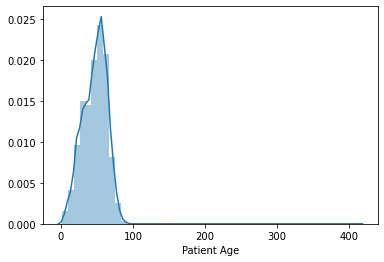

In [4]:
## EDA
# Todo 

### View patient demographics
sns.distplot(all_xray_df['Patient Age'])

In [5]:
all_xray_df['Patient Age'] = all_xray_df.apply(lambda x: 100 if x['Patient Age'] > 100 else x['Patient Age'], axis = 1)

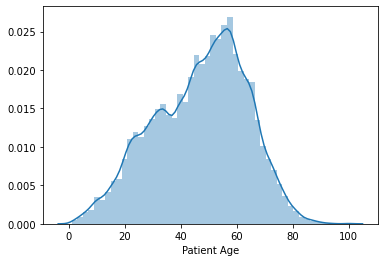

In [6]:
sns.distplot(all_xray_df['Patient Age'])

In [7]:
print(f'Age Mean: {all_xray_df["Patient Age"].mean()}')
print(f'Age median: {all_xray_df["Patient Age"].median()}')

Age Mean: 46.88015519086693
Age median: 49.0


In [8]:
print("Percent gender distribution: \n",(all_xray_df['Patient Gender'].value_counts() / all_xray_df.shape[0])*100)

Percent gender distribution: 
 M    56.493043
F    43.506957
Name: Patient Gender, dtype: float64


In [9]:
all_xray_df['Finding Labels'].value_counts()

No Finding                                                                                              60361
Infiltration                                                                                            9547 
Atelectasis                                                                                             4215 
Effusion                                                                                                3955 
Nodule                                                                                                  2705 
Pneumothorax                                                                                            2194 
Mass                                                                                                    2139 
Effusion|Infiltration                                                                                   1603 
Atelectasis|Infiltration                                                                                1350 
Consolidat

In [10]:
all_xray_df[all_xray_df['Finding Labels'].str.contains('Pneumonia')]['Finding Labels'].value_counts()

Pneumonia                                                                                         322
Infiltration|Pneumonia                                                                            199
Edema|Infiltration|Pneumonia                                                                      137
Atelectasis|Pneumonia                                                                             108
Edema|Pneumonia                                                                                   83 
Effusion|Pneumonia                                                                                54 
Effusion|Infiltration|Pneumonia                                                                   42 
Consolidation|Pneumonia                                                                           36 
Atelectasis|Infiltration|Pneumonia                                                                34 
Atelectasis|Effusion|Pneumonia                                                    

In [11]:
## Patients with no findings
print("Percent patients with no findings:", 
(all_xray_df[all_xray_df['Finding Labels'] == 'No Finding'].shape[0] / all_xray_df.shape[0])*100)

Percent patients with no findings: 53.83606849803782


In [12]:
findings = set()
for f in all_xray_df['Finding Labels'].unique():
    findings.update(f.split('|'))
print(f'Total number of single diagnoses: {len(findings)}')
findings

Total number of single diagnoses: 15


{'Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'No Finding',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax'}

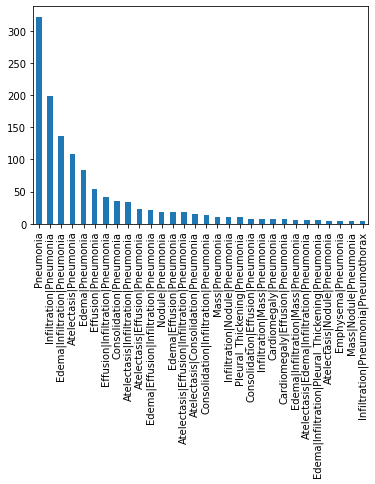

In [13]:
all_xray_df.loc[all_xray_df['Finding Labels'].str.contains('Pneumonia'), 'labels'] = 1
all_xray_df['labels'] = all_xray_df['labels'].fillna(0)

all_xray_df[all_xray_df['labels']==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar')


Text(0.5, 1.0, 'Pneumonia Age distribution vs Other')

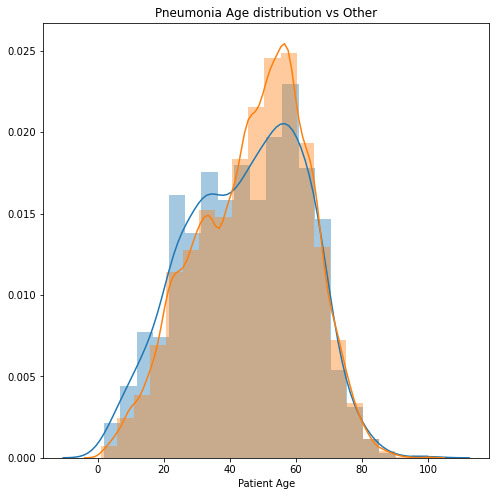

In [14]:
plt.figure(figsize=(8,8))
sns.distplot(all_xray_df[all_xray_df['labels'] == 1]['Patient Age'], bins=20)
sns.distplot(all_xray_df[all_xray_df['labels'] == 0]['Patient Age'], bins=20)
plt.title('Pneumonia Age distribution vs Other')

In [15]:
findings = list(findings)

In [16]:
print(f"Patients with Pneumonia: {all_xray_df['labels'].value_counts()}")

print(f"Percent pneumonia cases: {all_xray_df[all_xray_df['labels'] == 1].shape[0] / all_xray_df.shape[0]}")

Patients with Pneumonia: 0.0    110689
1.0    1431  
Name: labels, dtype: int64
Percent pneumonia cases: 0.012763110952550838


In [17]:
print("Patients with Pneumonia grouped by gender:")
all_xray_df.groupby("Patient Gender")["labels"].value_counts()

Patients with Pneumonia grouped by gender:


Patient Gender  labels
F               0.0       48187
                1.0       593  
M               0.0       62502
                1.0       838  
Name: labels, dtype: int64

## Pixel level assessment for different disorders

In [18]:
paths_img = {os.path.basename(c): c for c in glob(os.path.join('/data','images*', '*', '*.png'))}
sample_df['path_img'] = sample_df['Image Index'].map(paths_img.get)

In [19]:
sample_df

Image Index  \
0     00000013_005.png   
1     00000013_026.png   
2     00000017_001.png   
3     00000030_001.png   
4     00000032_001.png   
5     00000040_003.png   
6     00000042_002.png   
7     00000057_001.png   
8     00000061_002.png   
9     00000061_019.png   
10    00000061_025.png   
11    00000079_000.png   
12    00000080_005.png   
13    00000083_000.png   
14    00000084_000.png   
15    00000096_006.png   
16    00000099_003.png   
17    00000099_006.png   
18    00000103_001.png   
19    00000116_013.png   
20    00000116_019.png   
21    00000116_032.png   
22    00000116_040.png   
23    00000118_011.png   
24    00000121_004.png   
25    00000127_007.png   
26    00000132_002.png   
27    00000154_001.png   
28    00000165_008.png   
29    00000175_001.png   
30    00000175_002.png   
31    00000181_001.png   
32    00000181_017.png   
33    00000181_035.png   
34    00000188_001.png   
35    00000194_004.png   
36    00000206_000.png   
37    00000231_005.png   
38    00000232_000.png   
39    00000239_003.png   
40    00000242_000.png   
41    00000243_001.png   
42    00000246_003.png   
43    00000246_004.png   
44    00000246_011.png   
45    00000246_016.png   
46    00000246_018.png   
47    00000248_020.png   
48    00000250_005.png   
49    00000251_000.png   
50    00000265_004.png   
51    00000268_001.png   
52    00000269_001.png   
53    00000272_003.png   
54    00000276_000.png   
55    00000277_002.png   
56    00000278_000.png   
57    00000289_001.png   
58    00000318_004.png   
59    00000324_001.png   
60    00000334_005.png   
61    00000359_002.png   
62    00000359_006.png   
63    00000360_008.png   
64    00000362_001.png   
65    00000370_003.png   
66    00000372_002.png   
67    00000376_007.png   
68    00000390_000.png   
69    00000415_002.png   
70    00000417_001.png   
71    00000422_003.png   
72    00000422_005.png   
73    00000432_000.png   
74    00000439_000.png   
75    00000443_000.png   
76    00000444_001.png   
77    00000450_001.png   
78    00000459_004.png   
79    00000459_037.png   
80    00000467_013.png   
81    00000468_005.png   
82    00000468_007.png   
83    00000468_015.png   
84    00000468_045.png   
85    00000473_000.png   
86    00000479_000.png   
87    00000490_000.png   
88    00000491_004.png   
89    00000508_000.png   
90    00000521_000.png   
91    00000524_001.png   
92    00000531_001.png   
93    00000531_003.png   
94    00000531_005.png   
95    00000545_000.png   
96    00000545_004.png   
97    00000549_002.png   
98    00000549_003.png   
99    00000554_000.png   
100   00000556_000.png   
101   00000569_005.png   
102   00000580_001.png   
103   00000580_007.png   
104   00000583_016.png   
105   00000598_000.png   
106   00000599_000.png   
107   00000612_000.png   
108   00000618_007.png   
109   00000621_011.png   
110   00000623_009.png   
111   00000627_010.png   
112   00000627_017.png   
113   00000627_033.png   
114   00000627_036.png   
115   00000632_011.png   
116   00000632_012.png   
117   00000634_008.png   
118   00000642_000.png   
119   00000643_001.png   
120   00000649_000.png   
121   00000652_005.png   
122   00000662_001.png   
123   00000676_003.png   
124   00000682_001.png   
125   00000709_000.png   
126   00000727_002.png   
127   00000727_004.png   
128   00000733_003.png   
129   00000737_000.png   
130   00000742_000.png   
131   00000743_003.png   
132   00000744_003.png   
133   00000751_000.png   
134   00000758_000.png   
135   00000764_000.png   
136   00000766_002.png   
137   00000779_001.png   
138   00000781_006.png   
139   00000790_000.png   
140   00000797_004.png   
141   00000805_001.png   
142   00000807_000.png   
143   00000809_001.png   
144   00000814_005.png   
145   00000816_000.png   
146   00000820_003.png   
147   00000832_005.png   
148   00000835_000.png   
149   00000861_002.png   
150   00000865_004.png   
151   00000869_006.png   
152   00000872_006.png   
153   0

In [20]:
for finding in findings:
    sample_df[finding] = sample_df['Finding Labels'].map(lambda x: 1.0 if finding in x else 0)

sample_df.head(5)

Image Index                                          Finding Labels  \
0  00000013_005.png  Emphysema|Infiltration|Pleural_Thickening|Pneumothorax   
1  00000013_026.png  Cardiomegaly|Emphysema                                   
2  00000017_001.png  No Finding                                               
3  00000030_001.png  Atelectasis                                              
4  00000032_001.png  Cardiomegaly|Edema|Effusion                              

   Follow-up #  Patient ID Patient Age Patient Gender View Position  \
0  5            13          060Y        M              AP             
1  26           13          057Y        M              AP             
2  1            17          077Y        M              AP             
3  1            30          079Y        M              PA             
4  1            32          055Y        F              AP             

   OriginalImageWidth  OriginalImageHeight  OriginalImagePixelSpacing_x  \
0  3056                2544                 0.139                         
1  2500                2048                 0.168                         
2  2500                2048                 0.168                         
3  2992                2991                 0.143                         
4  2500                2048                 0.168                         

   OriginalImagePixelSpacing_y                                  path_img  \
0  0.139                        /data/images_001/images/00000013_005.png   
1  0.168                        /data/images_001/images/00000013_026.png   
2  0.168                        /data/images_001/images/00000017_001.png   
3  0.143                        /data/images_001/images/00000030_001.png   
4  0.168                        /data/images_001/images/00000032_001.png   

   Pneumonia  Edema  Infiltration  Mass  Consolidation  Hernia  Effusion  \
0  0.0        0.0    1.0           0.0   0.0            0.0     0.0        
1  0.0        0.0    0.0           0.0   0.0            0.0     0.0        
2  0.0        0.0    0.0           0.0   0.0            0.0     0.0        
3  0.0        0.0    0.0           0.0   0.0            0.0     0.0        
4  0.0        1.0    0.0           0.0   0.0            0.0     1.0        

   Fibrosis  No Finding  Atelectasis  Pleural_Thickening  Emphysema  \
0  0.0       0.0         0.0          1.0                 1.0         
1  0.0       0.0         0.0          0.0                 1.0         
2  0.0       1.0         0.0          0.0                 0.0         
3  0.0       0.0         1.0          0.0                 0.0         
4  0.0       0.0         0.0          0.0                 0.0         

   Cardiomegaly  Pneumothorax  Nodule  
0  0.0           1.0           0.0     
1  1.0           0.0           0.0     
2  0.0           0.0           0.0     
3  0.0           0.0           0.0     
4  1.0           0.0           0.0

In [21]:
paths_img = {os.path.basename(c): c for c in glob(os.path.join('/data','images*', '*', '*.png'))}
sample_df['path_img'] = sample_df['Image Index'].map(paths_img.get)

#### Healthy vs disease pixel intensities

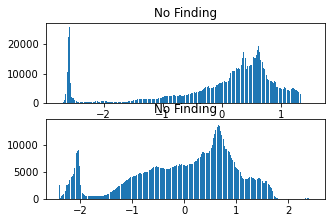

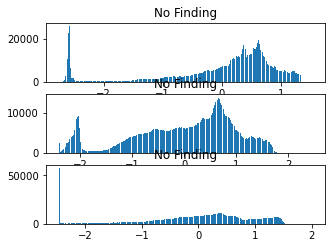

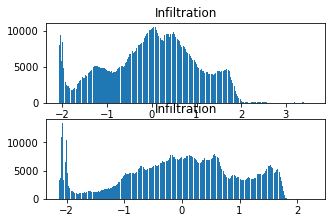

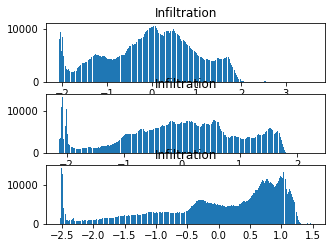

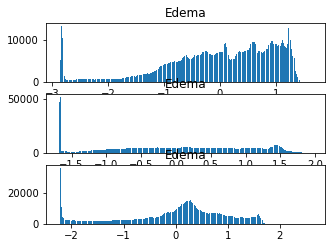

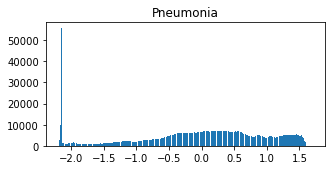

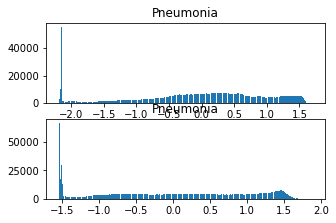

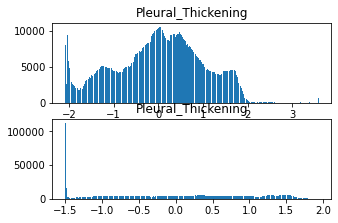

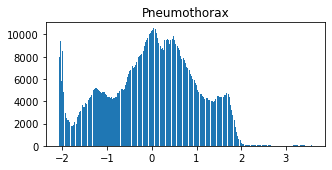

In [31]:
for i in ['No Finding', 'Infiltration', 'Edema', 'Pneumonia', 'Pleural_Thickening', 'Pneumothorax']:
    hist = sample_df[sample_df[i] == 1]
    data = []
    for p in range(3):
        data.append((i, hist.iloc[p]["path_img"]))
        plt.figure(figsize=(5, 5))
        columns = 1
        for j in range(len(data)):
            plt.subplot(len(data) / columns + 1, columns, j + 1).set_title(i)
            var = plt.imread(data[j][1])
            plt.hist(((var - np.mean(var))/np.std(var)).ravel(), bins=300)

Since Infiltration has the highest comorbidity with Pneumonia, we can compare individual pixel intensities between these two diseases. 

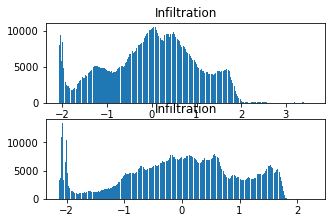

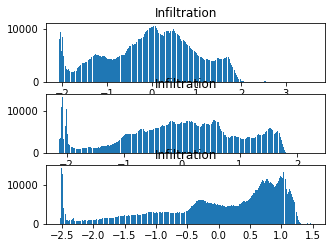

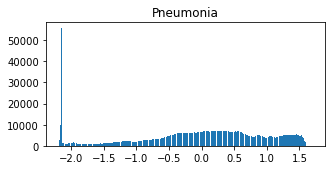

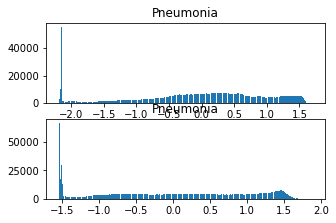

In [29]:
disease = ['Infiltration', 'Pneumonia']
for i in disease:
    hist = sample_df[sample_df[i] == 1]
    data = []
    for p in range(3):
        data.append((f, hist.iloc[p]["path_img"]))
        plt.figure(figsize=(5, 5))
        columns = 1
        for j in range(len(data) ):
            plt.subplot(len(data) / columns + 1, columns, j + 1).set_title(i)
            var = plt.imread(data[j][1])
            plt.hist(((var - np.mean(var))/np.std(var)).ravel(), bins=300)

## Discussion

- We can see that the data is noisy and may need some preprocessing steps.
- The images in the dataset need to normalized - the white foreground and black background can be removed using thresholds 0.1 (for white) and 0.9 (for black)
